**MI6 Debrief:**

> Should be have a flip flag for each metric? To identify good/bad *Solved, negative coefficients will account for that*

> Should we fill 0 to NA data? or fill it up by mean? *Used both*

> Missing data is an issue, regression wont run unless complete data

> Should we remove 2020 data from control variables *Have done, data only upto 2019 now*

> Have not included cuurency data yet, was not clear.*Phase 2*

> Inflation cleaned .xlsx is the latest version right?

**007, I'm your new Quartermaster.**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from functools import reduce
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bg

**What makes you think this is my first time?**

In [2]:
import warnings
warnings.filterwarnings("ignore")

**A gun and a radio...not exactly Christmas, is it?**

In [3]:
Dp_FDI_wide = pd.read_csv("Dp_FDI.csv")
#Dp_FDI_wide = pd.read_csv("FDI_yoy.csv")
Dp_PE_wide = pd.read_csv("Dp_PENew.csv")
Dp_Curr_wide = pd.read_csv("Dp_Curr.csv")
Dp_IntRate_wide = pd.read_csv("Dp_IntRate.csv")
Ind_TerrIdx = pd.read_csv("Ind_TerrIdx.csv")
Ind_TerrRaw = pd.read_csv("Ind_Terr.csv")
Cn_LaborForce_wide = pd.read_csv("Cn_LaborForce.csv")
Cn_GDPpc_wide = pd.read_csv("Cn_GDPpc.csv")
Cn_EODB_wide = pd.read_csv("EODBPercentiled.csv")
Cn_DomCrdt_wide = pd.read_csv("Cn_DomCrdt.csv")
Cn_FixedCapForm_wide = pd.read_csv("Cn_FixedCapForm.csv")
Cn_Infl_wide = pd.read_csv("Cn_Infl.csv")
Cn_IntRateL_wide = pd.read_csv("Cn_IntRateL.csv")
Cn_CurrStd_wide = pd.read_csv("Cn_CurrStd.csv")

In [4]:
Dp_FDI = pd.melt(Dp_FDI_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "FDI")
Dp_PE = pd.melt(Dp_PE_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "PE")
Dp_Curr = pd.melt(Dp_Curr_wide,id_vars = ("Year"), var_name = "Country Name", value_name = "Currency")
Dp_IntRate = pd.melt(Dp_IntRate_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "IntRate")
Cn_LaborForce = pd.melt(Cn_LaborForce_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "Lab")
Cn_GDPpc = pd.melt(Cn_GDPpc_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "GDPpc")
Cn_EODB = pd.melt(Cn_EODB_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "EODB")
Cn_DomCrdt = pd.melt(Cn_DomCrdt_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "DomCrdt")
Cn_FixedCapForm = pd.melt(Cn_FixedCapForm_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "FixedCapForm")
Cn_Infl = pd.melt(Cn_Infl_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "Inf")
Cn_IntRateL = pd.melt(Cn_IntRateL_wide,id_vars = ("Country Name"), var_name = "Year", value_name = "IntRateLend")
Cn_CurrStd = pd.melt(Cn_CurrStd_wide,id_vars = ("Year"), var_name = "Country Name", value_name = "CurStd")[["Country Name", "Year", "CurStd"]]
Cn_CurrStd["Year"] = Cn_CurrStd["Year"].apply(str)

In [5]:
# Merging control variables into one dataset
dfs = [Cn_LaborForce, Cn_GDPpc, Cn_EODB, Cn_DomCrdt,Cn_FixedCapForm, Cn_Infl, Cn_IntRateL,Cn_CurrStd]
Control_Matrix = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                        left_on=["Country Name","Year"], right_on = ["Country Name","Year"], how='outer'), dfs)
Control_Matrix["Year"] = pd.to_numeric(Control_Matrix["Year"])
Control_Matrix = Control_Matrix[Control_Matrix["Year"]<2020]
Control_Matrix["Year"] = Control_Matrix["Year"].apply(str)

**Be careful what you wish for.**

In [6]:
#1a. Terrorism Incidents Data as many gaps. So creating dummy '0' datapoints for completeness
Ind_Terr_Wide = Ind_TerrRaw.pivot(index="Year", columns="Country Name", values= "Incidents").reset_index(drop=False).fillna(0)
Ind_Terr = pd.melt(Ind_Terr_Wide,id_vars = ("Year"), var_name = "Country Name", value_name = "Incidents")

#1b. Including Terrorism Incidents Lag Variables
for i in range(0,len(Ind_Terr["Country Name"].unique())):
    country = Ind_Terr["Country Name"].unique()[i]
    Ter = Ind_Terr[Ind_Terr["Country Name"] == country]
    Ter["IncidentLag_5"] = Ter["Incidents"].shift(5)
    if i == 0:
        Ind_Terr_Ref = Ter
    else:
        Ind_Terr_Ref = pd.concat([Ind_Terr_Ref, Ter])
Ind_Terr_Ref.dropna(inplace=True)

#2a. Including Terrorism Index Lag Variables
for i in range(0,len(Ind_TerrIdx["Country Name"].unique())):
    country = Ind_TerrIdx["Country Name"].unique()[i]
    Ter = Ind_TerrIdx[Ind_Terr["Country Name"] == country]
    Ter["TerrorIdxLag_5"] = Ter["TerrIdx"].shift(5)
    if i == 0:
        Ind_TerrIdx_Ref = Ter
    else:
        Ind_TerrIdx_Ref = pd.concat([Ind_TerrIdx_Ref, Ter])
Ind_TerrIdx_Ref.dropna(inplace=True)

In [10]:
Ind_Terr

,Year,Country Name,Incidents
0,1994,Albania,2.0
1,1995,Albania,0.0
2,1996,Albania,6.0
3,1997,Albania,41.0
4,1998,Albania,7.0
...,...,...,...
2361,2015,Zambia,0.0
2362,2016,Zambia,0.0
2363,2017,Zambia,2.0
2364,2018,Zambia,0.0


In [11]:
Ind_TerrIdx

,Country Name,Year,TerrIdx
0,Yemen,2019,7.581
1,Pakistan,2019,7.541
2,Philippines,2019,7.099
3,Egypt,2019,6.419
4,Turkey,2019,6.110
...,...,...,...
1587,Iceland,2001,0.000
1588,Jamaica,2001,0.000
1589,Lesotho,2001,0.000
1590,Lithuania,2001,0.000


In [13]:
qwe = pd.merge(Ind_Terr, Ind_TerrIdx, left_on=["Country Name","Year"], right_on = ["Country Name","Year"], how='outer').dropna()

In [23]:
qwe1 = qwe.copy()
qwe1

,Year,Country Name,Incidents,TerrIdx
7,2001,Albania,1.0,0.614
8,2002,Albania,0.0,0.367
10,2004,Albania,0.0,0.048
11,2005,Albania,0.0,0.048
12,2006,Albania,0.0,0.010
...,...,...,...,...
2361,2015,Zambia,0.0,0.000
2362,2016,Zambia,0.0,0.663
2363,2017,Zambia,2.0,0.305
2364,2018,Zambia,0.0,0.153


In [30]:
qwe1 = qwe.pivot(index='Country Name', columns='Year', values='Incidents')
qwe1.to_csv("qwe1.csv", index=True)

In [31]:
qwe2 = qwe.pivot(index='Country Name', columns='Year', values='TerrIdx')
qwe2.to_csv("qwe2.csv", index=True)

In [19]:
qwe.to_csv("qwe.csv", index=True)

In [17]:
len(qwe["Country Name"].unique())

89

In [7]:
#Replcaing Nan values in Control Matrix with mean()
for i in range(0,len(Control_Matrix["Country Name"].unique())):
    country = Control_Matrix["Country Name"].unique()[i]
    Cntrl = Control_Matrix[Control_Matrix["Country Name"] == country]
    Cntrl.loc[:, ["Lab", "GDPpc", "EODB", "DomCrdt","FixedCapForm", "Inf", "IntRateLend"]] = Cntrl.loc[:, ["Lab", "GDPpc", "EODB", "DomCrdt","FixedCapForm", "Inf", "IntRateLend"]].apply(lambda x: x.fillna(x.mean()),axis=0)
    if i == 0:
        Control_Matrix_Ref = Cntrl
    else:
        Control_Matrix_Ref = pd.concat([Control_Matrix_Ref, Cntrl])
Control_Matrix_Ref.dropna(inplace=True)

In [8]:
#Combine and export database to check
Ind_Terr_Ref["Year"] = Ind_Terr_Ref["Year"].apply(str)
Ind_TerrIdx_Ref["Year"] = Ind_TerrIdx_Ref["Year"].apply(str)
Dp_Curr["Year"] = Dp_Curr["Year"].apply(str)
Dp_PE["Year"] = Dp_PE["Year"].apply(str)
#df2 = [Dp_FDI, Dp_PE, Dp_Curr, Dp_IntRate, Ind_Terr_Ref, Ind_TerrIdx_Ref, Control_Matrix_Ref]
df2 = [Dp_FDI, Ind_Terr_Ref, Ind_TerrIdx_Ref, Control_Matrix_Ref]
MergedFile = reduce(lambda df_left,df_right: pd.merge(df_left, df_right, 
                        left_on=["Country Name","Year"], right_on = ["Country Name","Year"], how='outer'), df2)
print("Before dropping NA",MergedFile.shape)
MergedFile.dropna(inplace = True)
print("After dropping NA",MergedFile.shape)

Before dropping NA (1931, 15)
After dropping NA (785, 15)


In [9]:
addvalue = abs(int(min(list(MergedFile.min()[2:]))/5 - 1)*5)

In [10]:
MergedFile.min()

Country Name        Albania
Year                   2001
FDI              -40.329928
Incidents               0.0
IncidentLag_5           0.0
TerrIdx                 0.0
TerrorIdxLag_5          0.0
Lab                   39.25
GDPpc            -13.519391
EODB                    1.0
DomCrdt            2.659869
FixedCapForm       6.295737
Inf              -18.898911
IntRateLend             0.0
CurStd             0.000115
dtype: object

In [22]:
addvalue

45

In [58]:
transform_type = "log"

In [59]:
if transform_type == "sqrt":
    MergedFile.iloc[:,2:] = MergedFile.iloc[:,2:]+addvalue
    MergedFile.iloc[:,2:] = np.sqrt(MergedFile.iloc[:,2:])
elif transform_type == "log":
    MergedFile.iloc[:,2:] = MergedFile.iloc[:,2:]+addvalue
    MergedFile.iloc[:,2:] = np.log(MergedFile.iloc[:,2:])

MergedFile

In [12]:
MergedFile

,Country Name,Year,FDI,Incidents,IncidentLag_5,TerrIdx,TerrorIdxLag_5,Lab,GDPpc,EODB,DomCrdt,FixedCapForm,Inf,IntRateLend,CurStd
93,Australia,2001,2.832402,2.0,5.0,0.115,0.229,63.56,0.565689,9.571429,88.651827,23.279665,4.620835,6.841667,0.221192
94,Bolivia,2001,8.668583,0.0,1.0,0.000,0.076,71.19,-0.235740,1.285714,49.293750,13.926773,1.870093,20.057061,0.538276
95,Canada,2001,3.841921,0.0,1.0,1.140,1.574,65.37,0.309870,9.428571,121.352832,20.151765,2.044026,5.812500,0.058173
96,Dominican Republic,2001,4.249316,0.0,3.0,0.000,0.000,58.37,0.942845,3.785714,23.570357,23.578260,6.040739,24.263333,0.857944
99,Guatemala,2001,-5.088204,2.0,26.0,1.033,1.562,62.22,-0.096568,3.857143,22.766713,18.601937,-5.610145,18.957500,0.812949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,Sierra Leone,2019,8.308342,0.0,0.0,0.229,0.296,57.89,3.396650,1.000000,6.108771,11.952537,8.538213,22.990000,2027.069065
1826,Ukraine,2019,3.789397,31.0,896.0,4.692,6.110,54.16,3.815825,5.000000,30.017994,17.610520,8.246955,19.821708,1.994713
1831,Tajikistan,2019,2.563730,2.0,1.0,4.180,4.614,39.68,4.863057,2.000000,11.582367,31.508865,3.658684,23.549707,1.311922
1833,Belarus,2019,1.976878,0.0,0.0,0.000,0.086,64.06,2.106840,7.000000,28.768881,27.034537,8.626733,9.023333,0.186606


In [11]:
import statsmodels.api as sm
result = sm.OLS(MergedFile[["FDI"]], 
                sm.add_constant(MergedFile[["TerrIdx","IncidentLag_5", "Lab", "GDPpc", "EODB",
                                            "DomCrdt","FixedCapForm","Inf", "IntRateLend","CurStd"]])
                , missing = "drop").fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FDI   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     6.655
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           5.84e-10
Time:                        19:57:12   Log-Likelihood:                -2652.8
No. Observations:                 785   AIC:                             5328.
Df Residuals:                     774   BIC:                             5379.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1010      2.363      1.735

> White's test for heteroskedacity

In [ ]:
result = sm.OLS(MergedFile[["FDI"]], 
                sm.add_constant(MergedFile[["TerrIdx","IncidentLag_5", "Lab", "GDPpc", "EODB",
                                            "DomCrdt","FixedCapForm","Inf", "IntRateLend","CurStd"]])
                , missing = "drop").fit()
print(result.summary())

In [61]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
wtest = het_white(result.resid, result.model.exog)
labels = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
lzip(labels, wtest)

[('Lagrange Multiplier statistic:', 51.08927178577846),
 ("LM test's p-value:", 0.896211779357197),
 ('F-statistic:', 0.7700200080266786),
 ("F-test's p-value:", 0.907163805063094)]

In [62]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bg
print(bg(result, nlags=2))

(1.3849749315313393, 0.5003299662269712, 0.6822231663111137, 0.5057964369543466)


In [63]:
print(bg(result, nlags=3))

(1.733594483878913, 0.6294909813489307, 0.5688151301004384, 0.6356752127555118)


In [53]:
qq = list(MergedFile.columns)
qq.pop(6)
qq.pop(8)
qq

['Country Name',
 'Year',
 'FDI',
 'PE',
 'Currency',
 'IntRate',
 'IncidentLag_5',
 'TerrIdx',
 'Lab',
 'GDPpc',
 'EODB',
 'DomCrdt',
 'FixedCapForm',
 'Inf',
 'IntRateLend',
 'CurStd']

In [55]:
MergedFile[qq]

,Country Name,Year,FDI,PE,Currency,IntRate,IncidentLag_5,TerrIdx,Lab,GDPpc,EODB,DomCrdt,FixedCapForm,Inf,IntRateLend,CurStd
93,Australia,2001,2.832402,0.06,0.121352,2.122744,5.0,0.115,63.56,0.565689,9.571429,88.651827,23.279665,4.620835,6.841667,0.221192
95,Canada,2001,3.841921,1.73,0.044342,3.692988,1.0,1.140,65.37,0.309870,9.428571,121.352832,20.151765,2.044026,5.812500,0.058173
102,Japan,2001,0.114465,1.45,0.129428,3.108265,8.0,1.544,62.24,0.164695,8.500000,183.181518,26.545463,-1.104517,1.969417,8.768044
105,Mexico,2001,3.972482,-2.75,-0.015496,6.368743,75.0,1.898,59.29,-1.792903,6.571429,12.877721,19.933701,6.041490,12.795000,0.653652
106,Netherlands,2001,12.058742,-9.04,0.031557,0.782403,6.0,1.413,63.47,1.557458,8.857143,110.464824,22.143641,4.184855,5.000000,0.109034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,Indonesia,2019,2.233379,0.14,-0.009109,8.629074,35.0,4.629,68.01,3.871444,5.000000,37.755009,32.347135,1.598798,10.365833,430.709308
1806,Norway,2019,4.206060,1.81,0.077790,3.689673,0.0,1.297,64.07,0.173378,10.000000,150.579097,25.629987,-0.437690,3.235833,0.277223
1811,Bulgaria,2019,3.027692,17.84,0.053279,-0.666042,1.0,0.172,56.75,4.426793,6.000000,49.796551,18.705342,5.250219,4.549208,0.046813
1814,Romania,2019,2.949754,3.73,0.075432,0.358462,0.0,0.000,55.13,4.677457,6.000000,24.753676,22.622141,6.778905,7.161667,0.112142


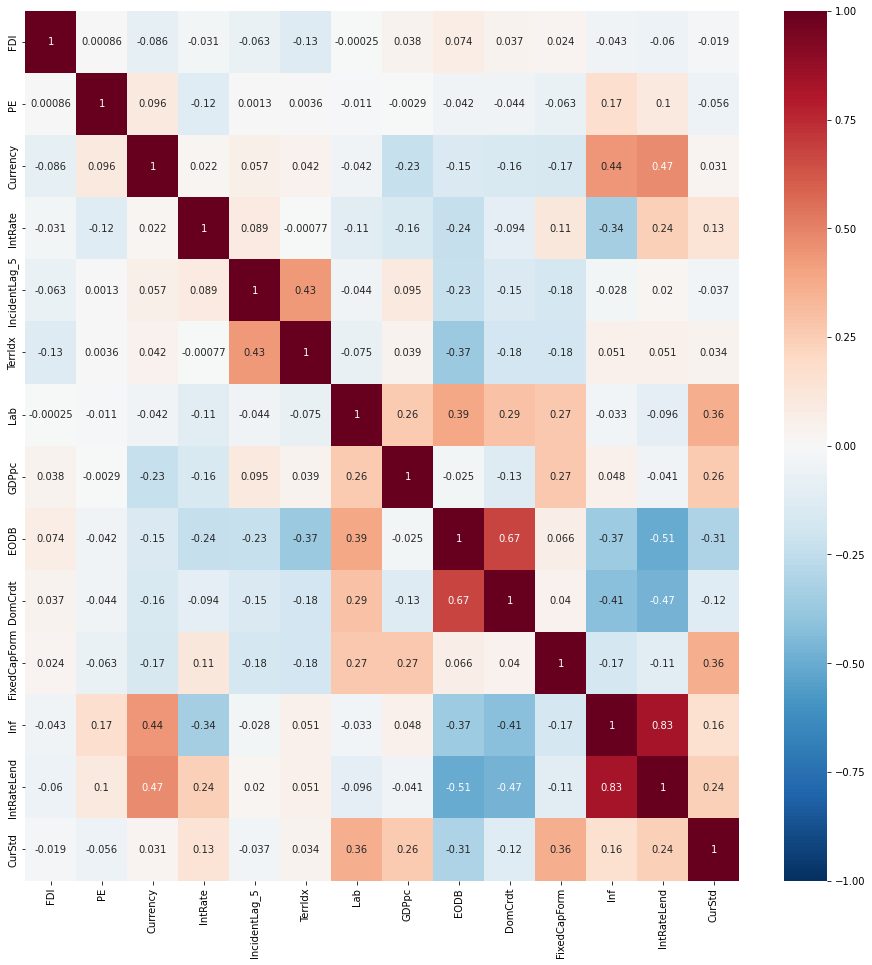

In [57]:
corrMatrix = MergedFile[qq].dropna().corr()
fig = plt.figure(figsize=(16, 16))
sns.heatmap(corrMatrix, annot=True,cmap='RdBu_r', vmin=-1, vmax=1)
fig.show()
fig.savefig('corrmatrix.png')  

> White test

In [73]:
Control_Matrix.dropna()

,Country Name,Year,Lab,GDPpc,EODB,DomCrdt,FixedCapForm,Inf,IntRateLend,CurStd
501,Australia,2006,64.91,1.289214,10.0,113.961207,27.877121,5.092354,7.612500,0.222298
504,Bulgaria,2006,52.32,7.616425,6.0,42.450446,27.437745,6.756898,8.892525,0.215156
506,Bolivia,2006,73.02,2.977253,3.0,37.800093,14.296679,13.663679,11.891283,0.355673
507,Botswana,2006,60.13,6.189760,7.0,20.484529,26.201046,7.473131,16.458333,0.664064
508,Canada,2006,66.58,3.118693,10.0,134.120807,22.885203,1.065703,5.812500,0.170039
...,...,...,...,...,...,...,...,...,...,...
1655,Uruguay,2019,63.90,-0.010199,4.0,25.717907,15.404333,8.522967,11.557185,3.038874
1656,United States,2019,62.57,1.697011,10.0,190.755995,20.785206,1.785152,5.282500,0.029155
1657,Vietnam,2019,77.37,6.001037,6.0,137.912126,24.232395,1.788599,7.707500,510.257117
1658,South Africa,2019,56.08,-1.157079,5.0,128.966353,17.899661,4.021221,10.125000,0.744516


In [108]:
Control_Matrix.columns = ['Country Name', 'Year', 'Labour Force(%)', 'GDP per capita Growth(%)', 'Ease Of Doing Business', 'Domestic Credit(% of GDP)','Fixed Capital Formation(% of GDP)', 'Inflation(%)', 'Lending IntRate(%)', 'Exchange Rate Volatility']

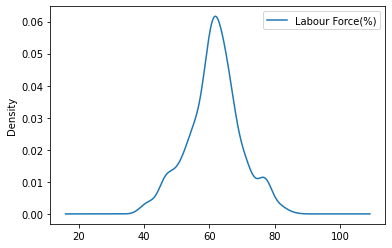

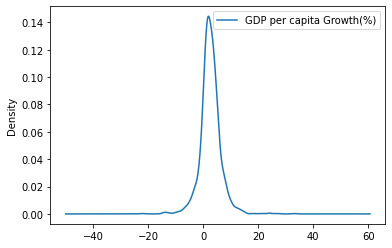

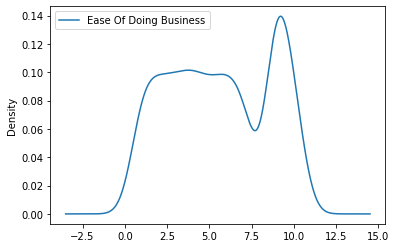

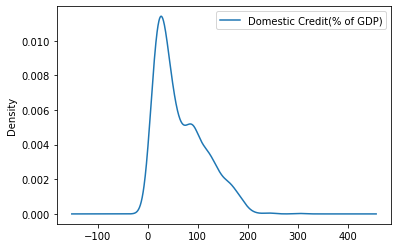

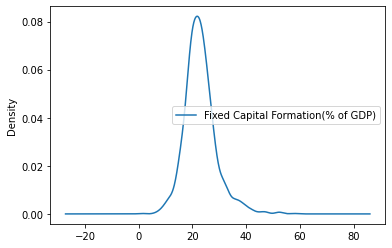

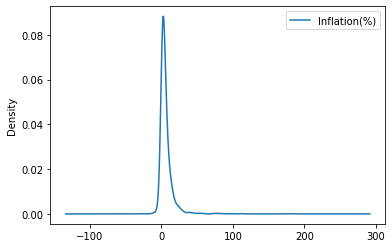

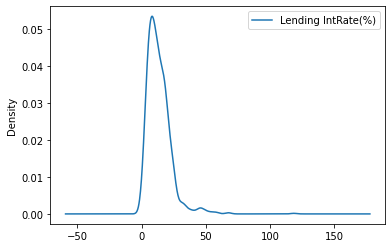

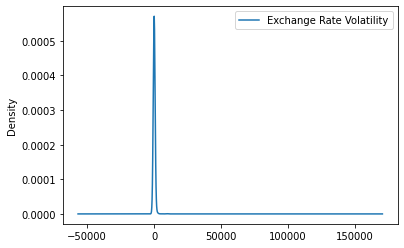

In [110]:
for i in Control_Matrix.columns[2:]:
    Control_Matrix[[i]].plot(kind='density')

In [112]:
MergedFile[qq]

,Country Name,Year,FDI,PE,Currency,IntRate,IncidentLag_5,TerrIdx,Lab,GDPpc,EODB,DomCrdt,FixedCapForm,Inf,IntRateLend,CurStd
93,Australia,2001,2.832402,0.06,0.121352,2.122744,5.0,0.115,63.56,0.565689,9.571429,88.651827,23.279665,4.620835,6.841667,0.221192
95,Canada,2001,3.841921,1.73,0.044342,3.692988,1.0,1.140,65.37,0.309870,9.428571,121.352832,20.151765,2.044026,5.812500,0.058173
102,Japan,2001,0.114465,1.45,0.129428,3.108265,8.0,1.544,62.24,0.164695,8.500000,183.181518,26.545463,-1.104517,1.969417,8.768044
105,Mexico,2001,3.972482,-2.75,-0.015496,6.368743,75.0,1.898,59.29,-1.792903,6.571429,12.877721,19.933701,6.041490,12.795000,0.653652
106,Netherlands,2001,12.058742,-9.04,0.031557,0.782403,6.0,1.413,63.47,1.557458,8.857143,110.464824,22.143641,4.184855,5.000000,0.109034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,Indonesia,2019,2.233379,0.14,-0.009109,8.629074,35.0,4.629,68.01,3.871444,5.000000,37.755009,32.347135,1.598798,10.365833,430.709308
1806,Norway,2019,4.206060,1.81,0.077790,3.689673,0.0,1.297,64.07,0.173378,10.000000,150.579097,25.629987,-0.437690,3.235833,0.277223
1811,Bulgaria,2019,3.027692,17.84,0.053279,-0.666042,1.0,0.172,56.75,4.426793,6.000000,49.796551,18.705342,5.250219,4.549208,0.046813
1814,Romania,2019,2.949754,3.73,0.075432,0.358462,0.0,0.000,55.13,4.677457,6.000000,24.753676,22.622141,6.778905,7.161667,0.112142


In [115]:
TempFile = MergedFile[qq].copy()

In [118]:
TempFile.columns = ['Country Name', 'Year','FDI(% of GDP)', 'P/E Ratio YoY(%)', 'Currency Exchange Rate YoY(%)', 'Real Interest Rate(%)',
       'IncidentLag_5', 'Terror Index', 'Labour Force(%)', 'GDP per capita Growth(%)', 'Ease Of Doing Business', 'Domestic Credit(% of GDP)','Fixed Capital Formation(% of GDP)', 'Inflation(%)', 'Lending IntRate(%)', 'Exchange Rate Volatility']

In [ ]:
['Country Name', 'Year','FDI(% of GDP)', 'P/E Ratio YoY(%)', 'Currency Exchange Rate YoY(%)', 'Real Interest Rate(%)',
       'IncidentLag_5', 'Terror Index', 'Labour Force(%)', 'GDP per capita Growth(%)', 'Ease Of Doing Business', 'Domestic Credit(% of GDP)','Fixed Capital Formation(% of GDP)', 'Inflation(%)', 'Lending IntRate(%)', 'Exchange Rate Volatility']

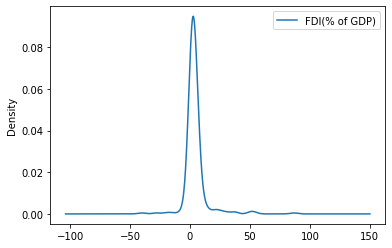

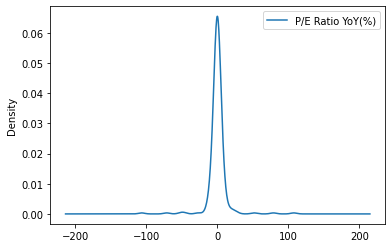

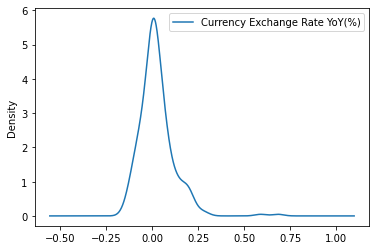

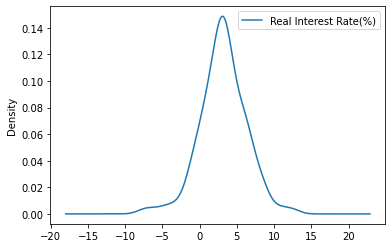

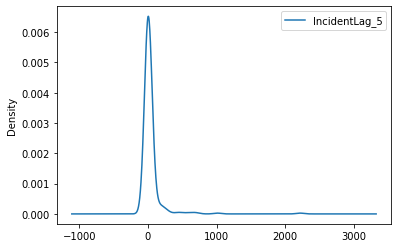

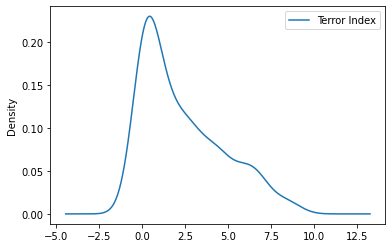

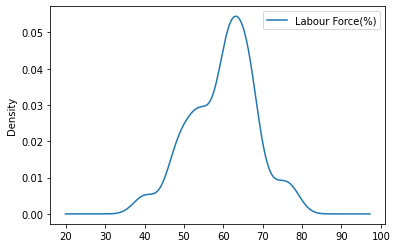

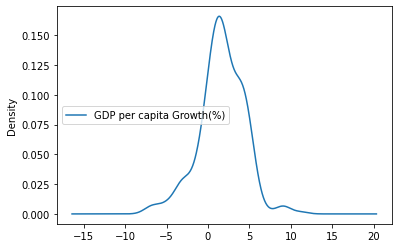

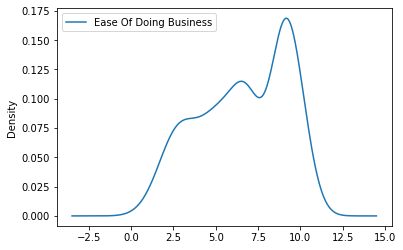

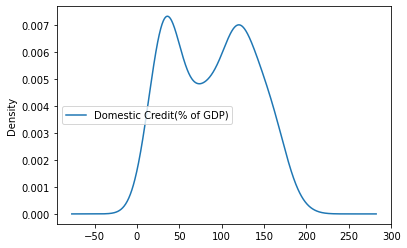

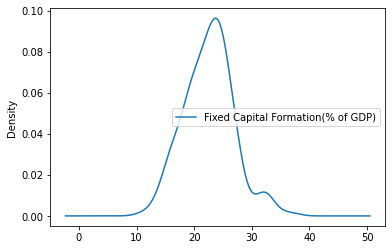

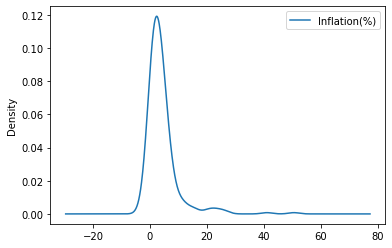

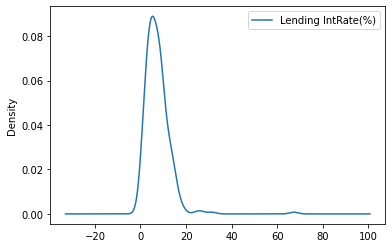

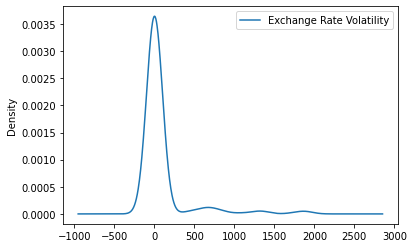

In [119]:
for i in TempFile.columns[2:]:
    TempFile[[i]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

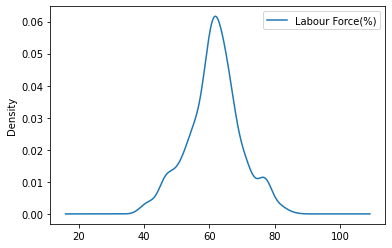

In [92]:
Control_Matrix[["Labour Force(%)"]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

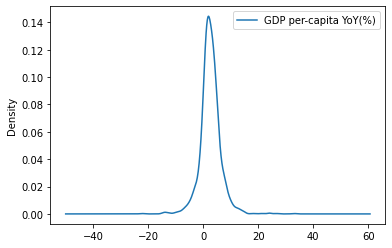

In [93]:
Control_Matrix[["GDP per-capita YoY(%)"]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

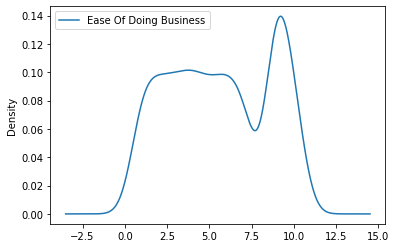

In [94]:
Control_Matrix[["Ease Of Doing Business"]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

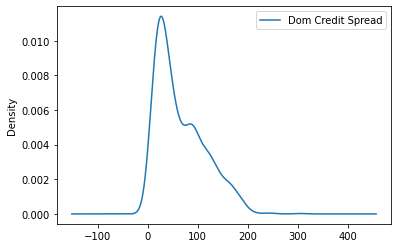

In [95]:
Control_Matrix[["Dom Credit Spread"]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

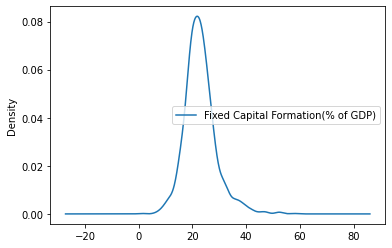

In [96]:
Control_Matrix[["Fixed Capital Formation(% of GDP)"]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

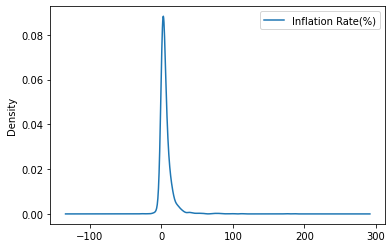

In [97]:
Control_Matrix[["Inflation Rate(%)"]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

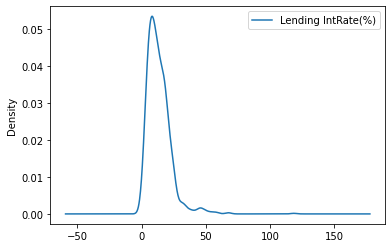

In [98]:
Control_Matrix[["Lending IntRate(%)"]].plot(kind='density')

<AxesSubplot:ylabel='Density'>

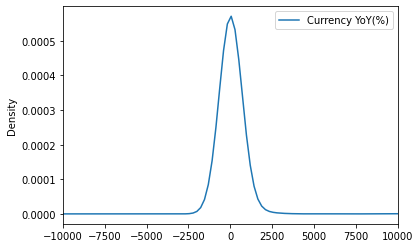

In [106]:
Control_Matrix[["Currency YoY(%)"]].plot(kind='density',xlim = (-10000,10000))

In [101]:
Control_Matrix.describe()

,Labour Force(%),GDP per-capita YoY(%),Ease Of Doing Business,Dom Credit Spread,Fixed Capital Formation(% of GDP),Inflation Rate(%),Lending IntRate(%),Currency YoY(%)
count,1660.000000,1646.000000,1246.000000,1408.000000,1563.000000,1646.000000,1099.000000,1872.000000
mean,61.537289,2.620804,5.605136,65.366671,22.920458,6.272396,13.410150,169.142205
std,8.107874,3.729308,2.984798,48.510246,5.953944,11.124863,9.434061,3059.614981
min,39.250000,-22.312096,1.000000,0.186170,1.096810,-27.631792,0.000000,0.000000
25%,56.882500,0.850142,3.000000,26.127579,19.343661,1.639056,7.122083,0.102280
50%,61.780000,2.446570,6.000000,50.305163,22.404184,3.594093,11.716667,0.625652
75%,66.105000,4.381945,9.000000,96.278900,25.632707,7.563514,17.542529,5.431590
max,85.870000,32.997066,10.000000,304.575113,57.710253,185.290761,118.379941,113790.155900


In [107]:
Control_Matrix[["Currency YoY(%)"]]

,Currency YoY(%)
0,20.291044
1,0.000237
2,50.864687
3,0.187072
4,0.112993
...,...
2019,18.860819
2020,18.009182
2021,12.725201
2022,9.648224


In [ ]:
,"GDPpc"

AttributeError: 'Line2D' object has no property 'kind'

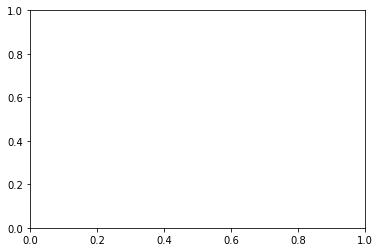

In [62]:
plt.plot(Control_Matrix[["Lab"]], kind = "density")

### for FDI, square root is the best one

In [ ]:
result = sm.OLS(MergedFile[["PE"]], sm.add_constant(MergedFile[["Incidents","IncidentLag_5","TerrIdx","TerrorIdxLag_5","Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRateLend","CurStd"]]), missing = "drop").fit()
print(result.summary())

In [ ]:
result = sm.OLS(MergedFile[["Currency"]], sm.add_constant(MergedFile[["Incidents","IncidentLag_5","TerrIdx","Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRateLend","CurStd"]]), missing = "drop").fit()
print(result.summary())

In [ ]:
result = sm.OLS(MergedFile[["IntRate"]], sm.add_constant(MergedFile[["Incidents","IncidentLag_5","TerrIdx","Lab", "GDPpc", "EODB", "DomCrdt","CurStd"]]), missing = "drop").fit()
print(result.summary())

In [ ]:
MergedFile

In [ ]:
f= open("Regression_droppingallna.txt","w+")
for dp in ["FDI","PE","Currency","IntRate"]:
    if dp == "IntRate":
        result = sm.OLS(MergedFile[[dp]], sm.add_constant(MergedFile[["TerrIdx","IncidentLag_5","Lab", "GDPpc", "EODB", "DomCrdt","CurStd"]]), missing = "drop").fit()
    else:
        result = sm.OLS(MergedFile[[dp]], sm.add_constant(MergedFile[["TerrIdx","IncidentLag_5","Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRateLend","CurStd"]]), missing = "drop").fit()
    print(result.summary())
    f.write(str(result.summary()))
f.close()


In [ ]:
countries = set(Ind_Terr["Country Name"].unique()).intersection(Control_Matrix["Country Name"].unique()).intersection(Dp_FDI["Country Name"].unique())

**Take the bloody shot!**

Y = intercept + α(Incident t) + α1(Incident t-1) + α2(Incident t-2) + α3(Incident t-3) + α4(Incident t-4) + α5(Incident t-5) + α6(Incident t-6) + αc1(Control Labour Force%) + ac2(Control GDPpc) + ac3(Control EODB) + ac4(Control Domestic Crdt Sprd) + ac5(Control Inflation) +ac6(Control Interest Rate) 

New Version

In [ ]:
#Run for specific Country
countries = ["Japan"]
for country in countries:
    print("Running", country)
    Cntrl = Control_Matrix[Control_Matrix["Country Name"] == country]
    #Filling NaN Values with mean()
    Cntrl.loc[:, ["Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRate"]] = Cntrl.loc[:, ["Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRate"]].apply(lambda x: x.fillna(x.mean()),axis=0)
    Ter = Ind_Terr[Ind_Terr["Country Name"] == country]
    cols = []
    for lag in range(1, lags + 1): 
        col = f"IncidentLag_{lag}"
        Ter[col] = Ter["Incidents"].shift(lag)
        cols.append(col)
    Ter.dropna(inplace = True)
    Dp = Dp_FDI[Dp_FDI["Country Name"] == country]
    Ind = pd.merge(Ter, Cntrl,  how='outer', left_on=["Country Name","Year"], right_on = ["Country Name","Year"])
    Dp.fillna(0, inplace = True)
    Ind.fillna(0, inplace = True)
    result = sm.OLS(Dp[["FDI"]].reset_index(drop=True), sm.add_constant(Ind[["Incidents","IncidentLag_1", "IncidentLag_2", "IncidentLag_3", "IncidentLag_4", "IncidentLag_5", "IncidentLag_6","Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRate","CurStd"]])).fit()
    print(result.summary())

Old Below

In [ ]:
FinalTable = pd.DataFrame(index = range(0,len(countries)))
FinalTable["Country"] = list(countries)
FinalTable["intercept"] = None
FinalTable["a"] = None
FinalTable["a1"] = None
FinalTable["a2"] = None
FinalTable["a3"] = None
FinalTable["a4"] = None
FinalTable["a5"] = None
FinalTable["a6"] = None
FinalTable["ac1"] = None
FinalTable["ac2"] = None
FinalTable["ac3"] = None
FinalTable["ac4"] = None
FinalTable["ac5"] = None
FinalTable["ac6"] = None

In [ ]:
for country in countries:
    print("Running", country)
    Cntrl = Control_Matrix[Control_Matrix["Country Name"] == country]
    #Filling NaN Values with mean()
    Cntrl.loc[:, ["Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRate"]] = Cntrl.loc[:, ["Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRate"]].apply(lambda x: x.fillna(x.mean()),axis=0)
    Ter = Ind_Terr[Ind_Terr["Country Name"] == country]
    cols = []
    for lag in range(1, lags + 1): 
        col = f"IncidentLag_{lag}"
        Ter[col] = Ter["Incidents"].shift(lag)
        cols.append(col)
    Ter.dropna(inplace = True)
    Dp = Dp_FDI[Dp_FDI["Country Name"] == country]
    Ind = pd.merge(Ter, Cntrl,  how='outer', left_on=["Country Name","Year"], right_on = ["Country Name","Year"])
    Dp.fillna(0, inplace = True)
    Ind.fillna(0, inplace = True)
    #print(len(Cntrl))
    #print(len(Ind))
    #print(len(Dp))
    Model = LinearRegression().fit(Ind[["IncidentLag_1", "IncidentLag_2", "IncidentLag_3", "IncidentLag_4", "IncidentLag_5"
                                        , "IncidentLag_6","Lab", "GDPpc", "EODB", "DomCrdt", "Inf", "IntRate"]],Dp[["FDI"]])
    #print(country, "Model Coefficients:", Model.coef_ , "Model Intercept:", Model.intercept_)
    FinalTable["intercept"][FinalTable["Country"]==country] = Model.intercept_
    FinalTable["a"][FinalTable["Country"]==country] = Model.coef_[0,0]
    FinalTable["a1"][FinalTable["Country"]==country] = Model.coef_[0,0]
    FinalTable["a2"][FinalTable["Country"]==country] = Model.coef_[0,1]
    FinalTable["a3"][FinalTable["Country"]==country] = Model.coef_[0,2]
    FinalTable["a4"][FinalTable["Country"]==country] = Model.coef_[0,3]
    FinalTable["a5"][FinalTable["Country"]==country] = Model.coef_[0,4]
    FinalTable["a6"][FinalTable["Country"]==country] = Model.coef_[0,5]
    FinalTable["ac1"][FinalTable["Country"]==country] = Model.coef_[0,0]
    FinalTable["ac2"][FinalTable["Country"]==country] = Model.coef_[0,0]
    FinalTable["ac3"][FinalTable["Country"]==country] = Model.coef_[0,0]
    FinalTable["ac4"][FinalTable["Country"]==country] = Model.coef_[0,0]
    FinalTable["ac5"][FinalTable["Country"]==country] = Model.coef_[0,0]
    FinalTable["ac6"][FinalTable["Country"]==country] = Model.coef_[0,0]

In [ ]:
FinalTable.to_csv("Regression_Output_v1.0.csv", index = False)

**Where the hell have you been? Enjoying death.**